In [ ]:
import numpy as np  # Linear algebra
import pandas as pd  # Data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Plotting

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
import seaborn as sns
from tqdm import tqdm

from imblearn.over_sampling import SMOTE, ADASYN


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline

Let's analyze the distribution of the variable y (response variable) by looking at the frequency of instances for each class.

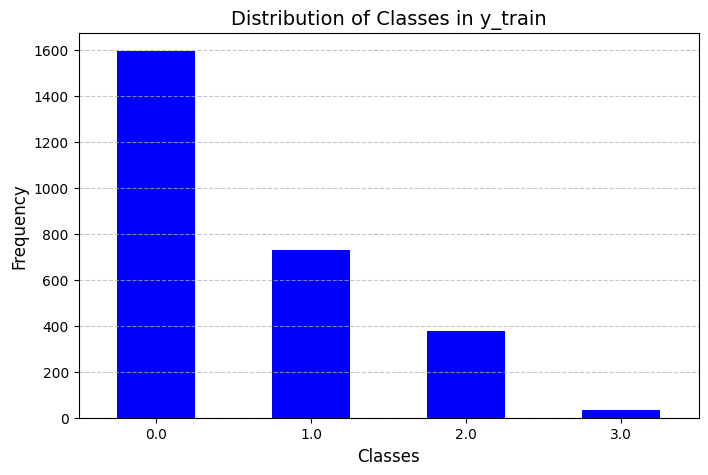

Baseline (Stupid Predictor Accuracy): 0.583


In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

# Put the "sii" column in y
y = train_data['sii']

test_data = test_data.drop(columns=['id'])

# Modify the training set to consider only the columns that are also present in the test set
common_columns = train_data.columns.intersection(test_data.columns)

X = train_data[common_columns]
test_data = test_data[common_columns]

y = y.dropna()
# Count the frequency of each class
class_counts = y.value_counts()

# Plot the distribution graph
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='blue')
plt.title('Distribution of Classes in y_train', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# "Stupid" predictor, baseline, simply predict the most frequent class
baseline_accuracy = class_counts.max() / class_counts.sum()
print(f"Baseline (Stupid Predictor Accuracy): {baseline_accuracy:.3f}")

## Conclusions

We can notice that in the response variable, the frequency of the classes is strongly imbalanced, so it can be inferred that appropriate methods will need to be used for the construction of a classifier.

The main techniques that can be used when dealing with an imbalanced dataset are:
  - Oversampling the minority class
  - Undersampling the majority class
      - We will not use this method, as the dataset at our disposal is not very large and we risk losing important information
  - Assigning weights to the classes that are inversely proportional to their frequency, this can be done during the use of Decision Tree (class weight = 'balanced')
  - Use of Ensemble methods, such as Random Forest, these models are designed to automatically balance the data during training

# Data preparation

- Processing of numerical features, with conversion, handling of NaNs, and creation of binary columns.
- Encoding of categorical features with LabelEncoder, also handling new categories in the test set.
- Filtering of common columns between train and test to avoid mismatches.
- Splitting the data into train, validation, and test sets for proper training and evaluation of models.

In [4]:
'''   Moduo   per la preparazione dei dati'''


def process_data(train, test):
    # Identifica le feature numeriche e categoriali
    numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = train.select_dtypes(include=['object']).columns

    '''
    Identifica le colonne numeriche (con >10 valori distinti), (una colonna che contiene dati numerici
    potrebbe comuqnue essere categoriale)'''
    is_numerical = np.array([len(np.unique(train[col].dropna())) > 10 for col in numerical_columns])
    numerical_idx = np.flatnonzero(is_numerical)

    # Elaborazione delle feuture numeriche
    X_train = pd.concat([
        train.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce'),  # Conversione in numerico, mette NaN dove fallisce
        train.iloc[:, numerical_idx].isna().astype(int)                       # Crea colonne binarie(solo per colonne numeriche) dove si sono i Nan
    ], axis=1).fillna(0.0)  # Sosotituisce i Nan con 0.0


    # Codifica delle feature categoriali con LabelEncoder
    categorical_idx = np.flatnonzero(is_numerical == False)
    label_encoders = {}


    #  categorical_idx   serve per selezionare solo le colonne categoriali
    for col in train.iloc[:, categorical_idx].columns:

        #si crea un LabelEncoder per ogni colonna, ognuno di essi è specifico per una colonna
        le = LabelEncoder()

        '''  addestra il LabelEncoder  sulla colonna corrente del training set, convertendola prima i valori in
        stringhe con   .astype(str)  (necessrio per evitare errori in caso di tipi misti).    Durante l'addestramento,
        il  LabelEncoder memorizza tutte le categorie uniche della colonna e le assegna a un numero intero univoco '''
        le.fit(train[col].astype(str))  # Converte in stringa per evitare problemi con NaN o tipi misti

        #salva il LabelEncoder addestrato in un dizionario  dove la chiave è il nome della colonna
        label_encoders[col] = le

        # trasformazione dei valori categoriali usando l'encoder addestrato
        train[col] = le.transform(train[col].astype(str))




    # Aggiunge le colonne categoriali codificate al training set(che sarebbe il dataframe X_train)
    X_train = pd.concat([X_train, train.iloc[:, categorical_idx]], axis=1)

    # Pre-elaborazione delle feature numeriche per il set di test
    X_test = pd.concat([
        test.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce'),   # Conversione in numerico, mette NaN dove fallisce
        test.iloc[:, numerical_idx].isna().astype(int)                       # Crea colonne binarie dove si sono i Nan
    ], axis=1).fillna(0.0)  # Sosotituisce i Nan con 0.0


    for col in test.iloc[:, categorical_idx].columns:
        le = label_encoders[col]  # Usa lo stesso LabelEncoder addestrato sul training set

        test[col] = test[col].astype(str)

        '''  Confronta le categorie presenti nella colonna del test set (test[col].unique()) con quelle
        note al LabelEncoder (le.classes_).
        unseen_labels conterrà le categorie che il LabelEncoder non ha mai incontrato. '''
        unseen_labels = set(test[col].unique()) - set(le.classes_)
        if unseen_labels:
            # Aggiunge gli la lista di unseen labels al LabelEncoder
            le.classes_ = np.append(le.classes_, list(unseen_labels))

        test[col] = le.transform(test[col])  # Trasforma i dati nel test set

    # Aggiunge le colonne categoriali codificate al test set
    X_test = pd.concat([X_test, test.iloc[:, categorical_idx]], axis=1)

    return X_train, X_test




def data_preprocessing(train_data, test_data):

    #metto in y la colanna dei "sii"
    y = train_data['sii']

    test_data = test_data.drop(columns=['id'])

    #modifico il set di training in modo da considerare solo le colonen che sono presenti anche nel set di test

    common_columns = train_data.columns.intersection(test_data.columns)

    X = train_data[common_columns]
    test_data = test_data[common_columns]


    #divisione in train e test(divisione casuale, garantendo che entrambi i set siano rappresentativi)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)


    X_train_enc, X_test_enc = process_data(X_train, X_test)

    # Processa i dati (X_train_enc e X_test_enc)

    # Rimuovo righe con valori NaN in y_train e y_test
    valid_rows_train = ~y_train.isna()  # Individua righe valide in y_train
    valid_rows_test = ~y_test.isna()    # Individua righe valide in y_test

    # Filtra X_train, X_test e y rimuovendo i NaN in y
    X_train = X_train[valid_rows_train]
    y_train = y_train[valid_rows_train]
    X_test = X_test[valid_rows_test]
    y_test = y_test[valid_rows_test]

    # Sincronizzo i dataset elaborati con le etichette filtrate
    X_train_enc = X_train_enc.loc[y_train.index]
    X_test_enc = X_test_enc.loc[y_test.index]



    #divido prima in train e validation e poi tetso il mio algoritmo

    X_train, X_valid, y_train, y_valid = train_test_split( X_train_enc, y_train,
                                                            test_size=0.25, random_state=42)



    return X_train, X_valid, X_test_enc, y_train, y_valid, y_test


# Decision Tree Classifier

In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

X_train, X_valid, X_test, y_train, y_valid, y_test = data_preprocessing(train_data, test_data)

In [6]:
def accuracies_vary_max_leaves(X_train, X_valid, X_test, y_train, y_valid, y_test,
                              l_min=2, l_max=50, l_step=1):

    accuracies = []

    for max_leaves in range(l_min,l_max, l_step):
        # train and predict
        dt = DecisionTreeClassifier(max_leaf_nodes=max_leaves, random_state=42)
        dt.fit(X_train,y_train)

        # compute Accuracy
        train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
        valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
        test_acc  = accuracy_score(y_true=y_test,  y_pred=dt.predict(X_test))

        accuracies += [ [max_leaves, train_acc, valid_acc, test_acc] ]

    accuracies = np.array(accuracies)

    fig, ax = plt.subplots()
    ax.plot(accuracies[:,0], accuracies[:,1], "x:", label="Train")
    ax.plot(accuracies[:,0], accuracies[:,2], "o-", label="Valid")
    ax.plot(accuracies[:,0], accuracies[:,3], "s-", label="Test")
    ax.legend()
    ax.grid()

    return accuracies

array([[ 2.        ,  0.60159074,  0.55194805,  0.56902357],
       [ 3.        ,  0.60448301,  0.56060606,  0.56004489],
       [ 4.        ,  0.61532899,  0.54978355,  0.5701459 ],
       [ 5.        ,  0.61532899,  0.54978355,  0.5701459 ],
       [ 6.        ,  0.61532899,  0.54978355,  0.5701459 ],
       [ 7.        ,  0.61605206,  0.56060606,  0.57126824],
       [ 8.        ,  0.62039046,  0.55844156,  0.57126824],
       [ 9.        ,  0.62039046,  0.55844156,  0.57126824],
       [10.        ,  0.62834418,  0.56060606,  0.56790123],
       [11.        ,  0.63268257,  0.56060606,  0.5634119 ],
       [12.        ,  0.63268257,  0.56060606,  0.5634119 ],
       [13.        ,  0.63485177,  0.55844156,  0.56228956],
       [14.        ,  0.64569776,  0.55844156,  0.5701459 ],
       [15.        ,  0.64569776,  0.55844156,  0.5701459 ],
       [16.        ,  0.65292842,  0.55411255,  0.56116723],
       [17.        ,  0.65582068,  0.55411255,  0.56116723],
       [18.        ,  0.

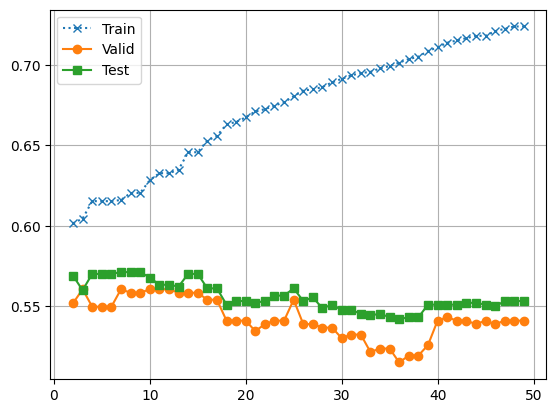

In [7]:
accuracies_vary_max_leaves(X_train, X_valid, X_test,
                           y_train, y_valid, y_test,
                           l_min=2, l_max=50)

In [8]:
dt = DecisionTreeClassifier( max_leaf_nodes=3, random_state=42)

dt.fit(X_train,y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
test_acc  = accuracy_score(y_true=y_test,  y_pred=dt.predict(X_test))


print (f"Train Acc: {train_acc:.3f}" )
print (f"Test Acc : {test_acc:.3f}" )

Train Acc: 0.604
Test Acc : 0.560


# Random forest

In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

X_train, X_valid, X_test, y_train, y_valid, y_test = data_preprocessing(train_data, test_data)

Risultati delle Accuratezze per ogni numero di alberi:


,Numero Alberi,Accuratezza Training,Accuratezza Test
0,1,0.805495,0.472503
1,5,0.926247,0.533109
2,10,0.978308,0.538721
3,25,0.991323,0.545455
4,30,0.994215,0.553311
5,35,0.994215,0.553311
6,40,0.995662,0.555556
7,45,0.995662,0.552189
8,50,0.994939,0.552189


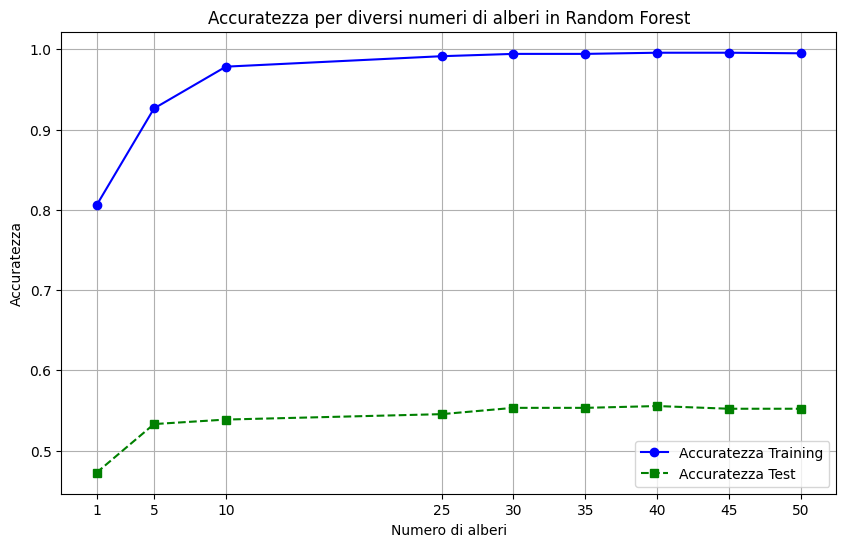

In [10]:
# Lista di numero di alberi da provare
n_trees = [1, 5, 10, 25, 30, 35, 40, 45, 50]

# Liste per salvare le accuratezze di ogni modello
train_accuracies = []
test_accuracies = []

# Loop per provare diversi modelli Random Forest con vari numeri di alberi
for t in n_trees:
    # Inizializzazione del modello Random Forest con il numero di alberi t e pesi bilanciati
    rf = RandomForestClassifier(n_estimators=t, class_weight='balanced', random_state=42)

    # Addestramento del modello
    rf.fit(X_train, y_train)

    # Calcolo delle accuratezze per training e test
    train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
    test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))

    # Salva i risultati
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Creazione di un DataFrame per visualizzare i risultati in formato tabellare
results_df = pd.DataFrame({
    'Numero Alberi': n_trees,
    'Accuratezza Training': train_accuracies,
    'Accuratezza Test': test_accuracies
})
print("Risultati delle Accuratezze per ogni numero di alberi:")
display(results_df)

# Visualizzazione dei risultati in un grafico
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_accuracies, marker='o', color='blue', linestyle='-', label='Accuratezza Training')
plt.plot(n_trees, test_accuracies, marker='s', color='green', linestyle='--', label='Accuratezza Test')
plt.title("Accuratezza per diversi numeri di alberi in Random Forest")
plt.xlabel("Numero di alberi")
plt.ylabel("Accuratezza")
plt.xticks(n_trees)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
'''  albero con migliore accuracy:   '''
rf = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42)

rf.fit(X_train,y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
test_acc  = accuracy_score(y_true=y_test,  y_pred=rf.predict(X_test))


print (f"Train Acc: {train_acc:.3f}" )
print (f"Test Acc : {test_acc:.3f}" )

Train Acc: 0.996
Test Acc : 0.556


Classi codificate: [0. 1. 2. 3.]


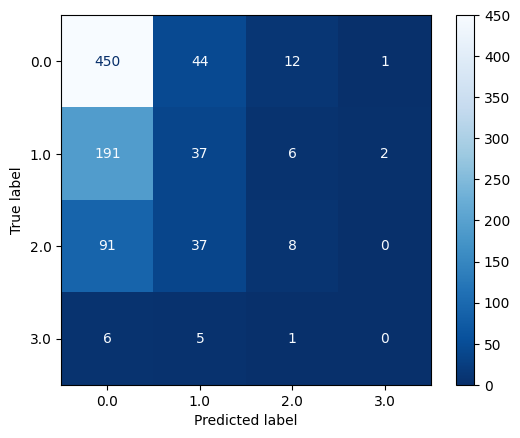

In [12]:
'''  Investighiamo in modo più approfondito le performance del randodm forest, attraverso
confusionn matrix   '''

label_enc = LabelEncoder()
label_enc.fit_transform(y_train)

ConfusionMatrixDisplay.from_estimator(
    estimator=rf,  #specifica il modello di classificazione
    X=X_test, y=y_test,
    display_labels=label_enc.classes_,
    cmap = 'Blues_r');


print("Classi codificate:", label_enc.classes_)

In [13]:
'''
analizzo le metriche: precisione, recall ed f1-score per ogni classe
output:   support: è il nuemro di campi effettivi per ciascuna classe nel datset
          Accuracy: Percentuale di predizioni totali corrette.
          Macro avg: Media aritmetica (non ponderata) delle metriche per tutte le classi.
          Weighted avg: Media ponderata delle metriche, dove le classi con più campioni hanno un peso maggiore.
'''
report = classification_report(y_true=y_test, y_pred=rf.predict(X_test))
print(report)

#RIVEDI QUESTA ANALISI, dato che il modello è stato cambiato

'''     Cosa possiamo concludere/dedurre dal report ottenuto e dall'analisi della con. Matrix:

classe 0: questa classe ha ottenuto dei buoni punteggi in tutte e 3 le metriche, quindi possiamo dire che il
          il modello performa bene per la classe 0, probabilmente perchè è la classe che continene più campioni
          e di conseguenza il modello ha più esempi per imparare.

classe 1: in questa classe le metriche hanno valori abbastanza bassi, in particolare il recall, dato che molti
          esempi della classe 1 vengono predetti come appartenenti ad altre classi(molte volte 0, dato che è la classe dominante)

classe 2: per questa classe i valori sono molto bassi per tutte le metriche(sopratutto recall), nonostante questi
          punteggi bassi, possimao comunque notare che questa classe non è estremamente sottorappresentata
          dato che ci sono 136 campioni per la classe. Il modello riconosce solo il 4% dei campioni effettivi
          appartenenti alla classe 2, potrebeb darsi che questa classe abbia caratteristiche troppo simili ad
          altre classi(ad esempio la classe 0, che è quella più rappresentata) dato anche che per 102 volte
          l'ha confusa con la classe 0.

classe 3: la classe ha 0 in tutte le metriche, probabilemnete perchè questa classe è esetremamente sottorappresentata
          infatti guardando il supproto, notiamo che ci sono solo 12 campioni, quindi è normale che il modello
          non abbia 2imparato" a riconoscerla.  (vedi se provare modello XGBoost)

Quindi8riassunto): il modello performa bene sulla classe più rappresentata (cioè 0), ma fatica molto con le altre(in particolare 2 e 3),
                   la classe 3 ha troppi pochi campioni, dati che siamo in un contesto  di salute mentale e
                   quindi qualcosa di collegato all'ambito medico, il fatto che il modello riesca a cogliere
                   poche volte le classi 2 e 3, che sono quelle che rappresentano i casì più gravi, la sua utilità
                   pratica viene ridotta drasticamente.

prossimo passo: analisi delle feauture.....
'''

              precision    recall  f1-score   support

         0.0       0.61      0.89      0.72       507
         1.0       0.30      0.16      0.21       236
         2.0       0.30      0.06      0.10       136
         3.0       0.00      0.00      0.00        12

    accuracy                           0.56       891
   macro avg       0.30      0.28      0.26       891
weighted avg       0.47      0.56      0.48       891



'     Cosa possiamo concludere/dedurre dal report ottenuto e dall\'analisi della con. Matrix:\n\nclasse 0: questa classe ha ottenuto dei buoni punteggi in tutte e 3 le metriche, quindi possiamo dire che il\n          il modello performa bene per la classe 0, probabilmente perchè è la classe che continene più campioni\n          e di conseguenza il modello ha più esempi per imparare.\n\nclasse 1: in questa classe le metriche hanno valori abbastanza bassi, in particolare il recall, dato che molti\n          esempi della classe 1 vengono predetti come appartenenti ad altre classi(molte volte 0, dato che è la classe dominante)\n\nclasse 2: per questa classe i valori sono molto bassi per tutte le metriche(sopratutto recall), nonostante questi\n          punteggi bassi, possimao comunque notare che questa classe non è estremamente sottorappresentata\n          dato che ci sono 136 campioni per la classe. Il modello riconosce solo il 4% dei campioni effettivi\n          appartenenti alla clas

Number of selected features: 71
Set of selected features:
Index(['Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height',
       'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Time_Mins', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',
       'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW',
       'BIA-BIA_LDM', 'BIA-BIA_LST', 'CGAS-Season', 'CGAS-CGAS_Score',
       'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Enduran

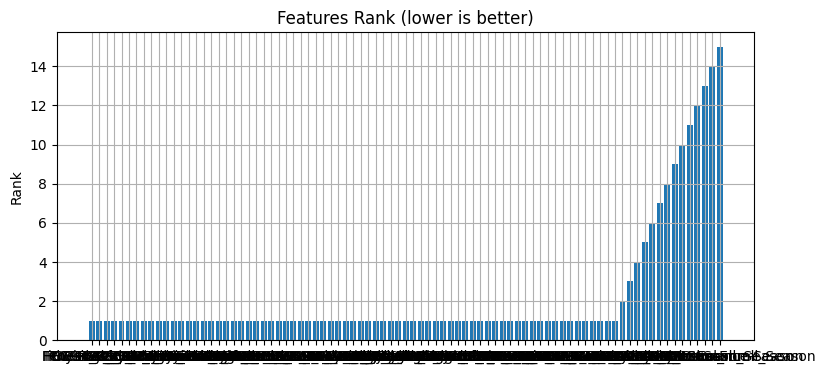

In [15]:
#NON RUNNARE IN LOCALE


'''  selezione delle feauture più rilevanti, mi fa vedere a schermo le feauture in ordine di rilevanaza  '''


'''   Recursive Feature Elimination with Cross-Validation (RFECV)     '''
selector = RFECV(rf,
                 step=1, # Rimuovo una feauture alla volta durante il processo di eliminazione
                 cv=5,   # cross validation folds
                 scoring='accuracy', # usa l'accuracy come metrica per la valutazione
                 min_features_to_select=1 # garantisce che almeno una feauture venga scelta
                )


# Fit RFE to your data (X_train_enc, y_train_enc - make sure you use the encoded labels)
selector.fit(X_train, y_train);

# Print the number of selected features
print (f"Number of selected features: {selector.n_features_}")

# Get feature names from your training data
feature_names = X_train.columns

# Print the selected features
print ("Set of selected features:");
print (feature_names[selector.support_])

# Create the feature ranking plot
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(range(0,X_train.shape[1]), sorted(selector.ranking_))
ax.set_title("Features Rank (lower is better)")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(feature_names[np.argsort(selector.ranking_)])
ax.set_ylabel("Rank")
ax.grid();
plt.show()

Full score: 0.58
Best score: 0.60


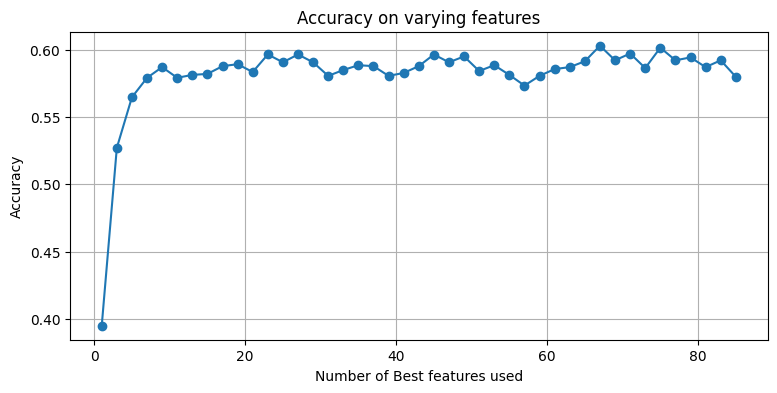

In [16]:
#NON RUNNARE IN LOCALE


#valutazione progressiva del contributo di ciascuna feauture in un modello di regressione  Random Forest
#contiene il punteggio di importanza delle feuture, np.argsort() ordina gli indici delle feautures,
best_features = np.argsort(rf.feature_importances_)[::-1]  # [::-1] fa il reverse, ordina gli indici in modo decrescente
#per memorizzare RMSE(errore quadratico medio)
accuracy = []
for f in range(1,len(best_features)+1, 2):
    rf_small = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42) # Use RandomForestClassifier
    rf_small.fit(X_train.iloc[:,best_features[:f]], y_train) # Fit the model with selected features
    scores = cross_val_score(rf_small,
                             X_train.iloc[:,best_features[:f]], y_train, # Use X_train with selected features
                             cv=5, scoring='accuracy') # Use 'neg_mean_squared_error'
    accuracy += [scores.mean()]   #fa la media delle varie accuracy ottenute
print (f"Full score: {accuracy[-1]:.2f}")
print (f"Best score: {max(accuracy):.2f}")


fig, ax = plt.subplots(figsize=(9,4))
ax.plot(range(1,len(best_features)+1, 2), accuracy, 'o-', label="Accuracy")
ax.set_title("Accuracy on varying features")
ax.set_xlabel("Number of Best features used")
ax.set_ylabel("Accuracy")
ax.grid()
plt.show()

In [ ]:
#NON RUNNARE IN LOCALE


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
'''  RIVEDI E VALUTA SE TOGLIERE QUESTO PEZZO  '''


# identifico il miglior numero di feuture che mi produce la migliore accuracy
best_num_features = (accuracy.index(max(accuracy)) * 2) + 1


# Utilizza queste feature per addestrare un nuovo modello di RandomForestClassifier
rf_best = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42)
rf_best.fit(X_train.iloc[:, best_features[:best_num_features]], y_train)

# Valuta le performance del nuovo modello (LO FA SOLO NEL TRAINING)
scores = cross_val_score(rf_best,
                         X_train.iloc[:, best_features[:best_num_features]],
                         y_train,
                         cv=5,
                         scoring='accuracy')

print(f"Accuracy with best features(solo nel trainig): {scores.mean():.2f}")

# Get the common features between X_train and X_test
common_features = X_train.columns.intersection(X_test.columns)

# Filter best_features to include only common features
best_features_common = [f for f in best_features if X_train.columns[f] in common_features]

# Puoi anche valutare il modello sul set di test se disponibile, using common features
test_accuracy = rf_best.score(X_test.loc[:, X_train.columns[best_features_common[:best_num_features]]], y_test)
print(f"Test Accuracy with best features: {test_accuracy:.2f}")

# XGBoost

In [ ]:

''' FUNZIONI per preprocessing dtai, sono uguali, però in questo caso, per l'XGBoost non si getsiscono i Nan, dato che se li gestisce da solo '''

def process_data_XG(train, test):
    '''
    Quasi uguale allimplementazione degli altri modelli, solo che questo è per
    XGBoost e quindi i valori Nan vengono lasciati.
    '''
    # Identifica le feature numeriche e categoriali
    numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = train.select_dtypes(include=['object']).columns

    # Identifica le colonne numeriche (con >10 valori distinti)
    is_numerical = np.array([len(np.unique(train[col].dropna())) > 10 for col in numerical_columns])
    numerical_idx = np.flatnonzero(is_numerical)

    # Elaborazione delle feature numeriche (senza conversione NaN)
    X_train = train.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce')

    # Codifica delle feature categoriali con LabelEncoder
    categorical_idx = np.flatnonzero(is_numerical == False)
    label_encoders = {}

    for col in train.iloc[:, categorical_idx].columns:
        le = LabelEncoder()
        le.fit(train[col].astype(str))
        label_encoders[col] = le
        train[col] = le.transform(train[col].astype(str))

    X_train = pd.concat([X_train, train.iloc[:, categorical_idx]], axis=1)

    # Pre-elaborazione delle feature numeriche per il set di test (senza conversione NaN)
    X_test = test.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce')

    for col in test.iloc[:, categorical_idx].columns:
        le = label_encoders[col]
        test[col] = test[col].astype(str)
        unseen_labels = set(test[col].unique()) - set(le.classes_)
        if unseen_labels:
            le.classes_ = np.append(le.classes_, list(unseen_labels))
        test[col] = le.transform(test[col])

    X_test = pd.concat([X_test, test.iloc[:, categorical_idx]], axis=1)

    return X_train, X_test




def data_preprocessing_XG(train_data, test_data):

    #metto in y la colanna dei "sii"
    y = train_data['sii']

    test_data = test_data.drop(columns=['id'])

    #modifico il set di training in modo da considerare solo le colonen che sono presenti anche nel set di test

    common_columns = train_data.columns.intersection(test_data.columns)

    X = train_data[common_columns]
    test_data = test_data[common_columns]


    #divisione in train e test(divisione casuale, garantendo che entrambi i set siano rappresentativi)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)


    X_train_enc, X_test_enc = process_data_XG(X_train, X_test)

    # Processa i dati (X_train_enc e X_test_enc)

    # Rimuovo righe con valori NaN in y_train e y_test
    valid_rows_train = ~y_train.isna()  # Individua righe valide in y_train
    valid_rows_test = ~y_test.isna()    # Individua righe valide in y_test

    # Filtra X_train, X_test e y rimuovendo i NaN in y
    X_train = X_train[valid_rows_train]
    y_train = y_train[valid_rows_train]
    X_test = X_test[valid_rows_test]
    y_test = y_test[valid_rows_test]

    # Sincronizzo i dataset elaborati con le etichette filtrate
    X_train_enc = X_train_enc.loc[y_train.index]
    X_test_enc = X_test_enc.loc[y_test.index]



    #divido prima in train e validation e poi tetso il mio algoritmo

    X_train, X_valid, y_train, y_valid = train_test_split( X_train_enc, y_train,
                                                            test_size=0.25, random_state=42)



    return X_train, X_valid, X_test_enc, y_train, y_valid, y_test



In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

X_train, X_valid, X_test, y_train, y_valid, y_test = data_preprocessing_XG(train_data, test_data)

In [ ]:
''' NON far runnare questa, ci mette 15/20 minuti    '''


'''
Trovo i migliori parametri per il modello XGBoost, per ridurre il tempo di addestramento
utilizzo il RandomizedSearchCV  al posto del GridSearchCV
'''



# Definisci il modello XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Definisci la griglia di iperparametri da testare
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

for params in tqdm(param_grid):
  random_search = RandomizedSearchCV(
      estimator=xgb_model,
      param_distributions=param_grid,
      scoring='accuracy',
      cv=5,
      n_iter=30,  # Numero di combinazioni casuali da testare
      random_state=42,
      verbose=1,
      n_jobs=-1
  )
  # Addestra il modello con GridSearchCV
  random_search.fit(X_train, y_train)

# Stampa i migliori iperparametri trovati
print(random_search.best_params_)

In [ ]:
'''
Alleno il modello XGBoost con i migliori parametri trovati
'''

# Definisci il modello XGBoost
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Definisci la griglia di iperparametri da testare
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],   #quanto ogni albero contribuisce al modello(valori più bassi rendono il modello più robusto, ma il training è più lento)
    'max_depth': [3, 5, 7],   #profondità massima di ogni albero(alberi più profondi catturano più dettgali, ma c'è rischio overfitting)
    'n_estimators': [50, 100, 150],  #numero di alberi da creare
    'subsample': [0.8, 0.9, 1.0],   #frazione di campioni da utilizzare per addestrare ciascun albero
    'colsample_bytree': [0.8, 0.9, 1.0]  #frazione di feature da utilizzare per addestrare ciascun albero
}


# Supponiamo che questi siano i migliori parametri trovati da una precedente esecuzione
best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 50,
    'subsample': 0.8,
    'colsample_bytree': 0.9
}


'''
Qui vado ad inserire manualmente i parametri nel modello, per non dover runnare
di nuovo il RandomizedSearchCV, dato che ci mette troppo tempo.
'''
# Crea un oggetto RandomizedSearchCV (ma non eseguire la ricerca)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,  # param_grid è ancora necessario
    scoring='accuracy',
    cv=5,
    n_iter=1,  # Impostato a 1 per evitare il fitting, questo viene utilizzato per simulare un singolo fit.
    random_state=42,
    verbose=0,
    n_jobs=-1
)

# Imposta manualmente i migliori parametri
random_search.best_params_ = best_params

# Ora puoi usare random_search.best_params_ come prima
# ad esempio:
#best_xgb_model = xgb.XGBClassifier(**random_search.best_params_, objective='multi:softmax', num_class=4, random_state=42)
#best_xgb_model.fit(X_train, y_train)

d:\PROGRAMMI\python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.5541125541125541
Test Accuracy: 0.5600448933782267


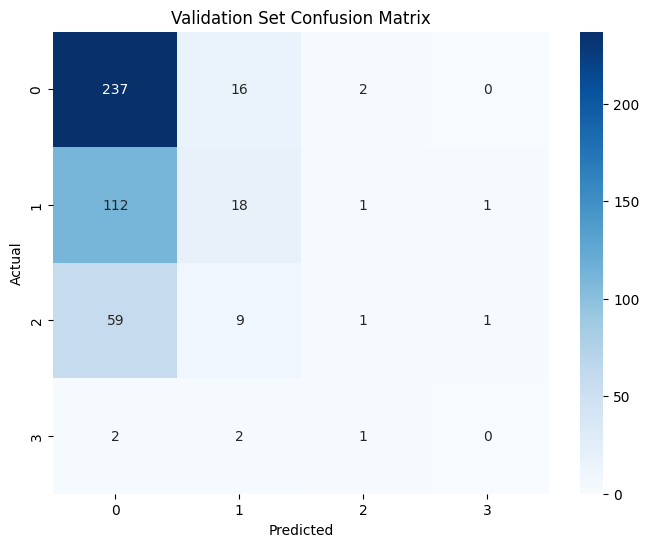

              precision    recall  f1-score   support

         0.0       0.58      0.93      0.71       255
         1.0       0.40      0.14      0.20       132
         2.0       0.20      0.01      0.03        70
         3.0       0.00      0.00      0.00         5

    accuracy                           0.55       462
   macro avg       0.29      0.27      0.24       462
weighted avg       0.46      0.55      0.46       462


Analysis for Validation Set Confusion Matrix:


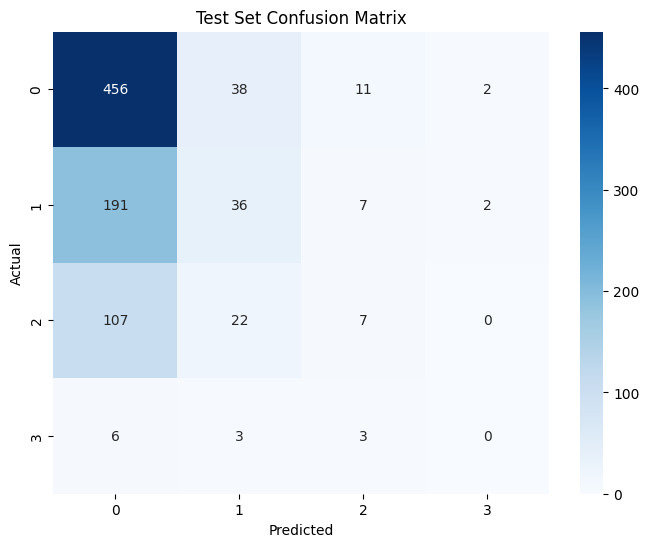

              precision    recall  f1-score   support

         0.0       0.60      0.90      0.72       507
         1.0       0.36      0.15      0.21       236
         2.0       0.25      0.05      0.09       136
         3.0       0.00      0.00      0.00        12

    accuracy                           0.56       891
   macro avg       0.30      0.28      0.26       891
weighted avg       0.48      0.56      0.48       891


Analysis for Test Set Confusion Matrix:


In [ ]:
'''
Test del modello, sia con validation che con test.  Poi analisi dei risultati....
'''

classes = np.unique(y_train) # Assuming y_train contains your training labels


best_params = random_search.best_params_

best_xgb_model = xgb.XGBClassifier(**best_params, class_weight='balanced', objective='multi:softmax', num_class=4, random_state=42)
best_xgb_model.fit(X_train, y_train)

# validation
y_pred_valid = best_xgb_model.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Accuracy: {accuracy_valid}")


# test
y_pred_test = best_xgb_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")



# **Confusion Matrix and Analysis**
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(classification_report(y_true, y_pred)) #Print classification report with precision, recall, f1-score

    # **Analysis (Example)**
    print(f"\nAnalysis for {title}:")
    # Add specific analysis points based on the confusion matrix
    # Example:
    # print(f"  - Most frequent misclassification: Class {cm.argmax()} predicted as Class {cm.argmin()}")


plot_confusion_matrix(y_valid, y_pred_valid, "Validation Set Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_test, "Test Set Confusion Matrix")



#accuracy = accuracy_score(y_test_enc, y_pred)  # oppure y_valid se usi il validation set

# Stampa l'accuracy
#print(f"Accuracy: {accuracy}")